In [ ]:
# Import core libraries for data handling, visualization, scaling,
# feature selection, and modeling
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

import plotly.express as px

# Display full columns, apply clean visualization style, and set default figure size
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid", palette="pastel")
plt.rcParams["figure.figsize"] = (8, 40)


In [ ]:
# Load the Math and Portuguese datasets from the UCI repository
math_df = pd.read_csv("/content/student-mat.csv", sep=";")
por_df  = pd.read_csv("/content/student-por.csv", sep=";")

print("Math dataset shape:", math_df.shape)
print("Portuguese dataset shape:", por_df.shape)

display(math_df.head(3))
display(por_df.head(3))


Math dataset shape: (395, 33)
Portuguese dataset shape: (649, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12


In [ ]:
# Define the common identifier columns needed to match the same student in both datasets
merge_cols = [
    "school","sex","age","address","famsize","Pstatus",
    "Medu","Fedu","Mjob","Fjob","reason","nursery","internet"
]

# Merge Math and Portuguese datasets on shared student attributes
merged_df = pd.merge(
    math_df,
    por_df,
    on=merge_cols,
    suffixes=("_math", "_por")
)

print("Merged dataset shape:", merged_df.shape)
display(merged_df.head(3))


Merged dataset shape: (382, 53)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian_math,traveltime_math,studytime_math,failures_math,schoolsup_math,famsup_math,paid_math,activities_math,nursery,higher_math,internet,romantic_math,famrel_math,freetime_math,goout_math,Dalc_math,Walc_math,health_math,absences_math,G1_math,G2_math,G3_math,guardian_por,traveltime_por,studytime_por,failures_por,schoolsup_por,famsup_por,paid_por,activities_por,higher_por,romantic_por,famrel_por,freetime_por,goout_por,Dalc_por,Walc_por,health_por,absences_por,G1_por,G2_por,G3_por
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6,mother,2,2,0,yes,no,no,no,yes,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6,father,1,2,0,no,yes,no,no,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10,mother,1,2,0,yes,no,no,no,yes,no,4,3,2,2,3,3,6,12,13,12


In [ ]:
merged_df.drop_duplicates(inplace=True)

# Count total missing values
total_na = merged_df.isna().sum().sum()
print("Total missing values before handling:", total_na)


for col in merged_df.columns:
    if merged_df[col].dtype == "O":
        merged_df[col] = merged_df[col].fillna(merged_df[col].mode()[0])
    else:
        merged_df[col] = merged_df[col].fillna(merged_df[col].mean())

print("Total missing values after handling:", merged_df.isna().sum().sum())


Total missing values before handling: 0
Total missing values after handling: 0


In [ ]:
# HANDLE YES/NO → 1/0

# Many columns are 'yes'/'no'. We will convert ALL such columns to 1/0.

# Find all object columns
obj_cols = merged_df.select_dtypes(include="object").columns.tolist()

# For each object column, if its unique values are subset of {'yes', 'no'}, map to 1/0
for col in obj_cols:
    unique_vals = set(merged_df[col].unique())
    if unique_vals.issubset({"yes", "no"}):
        merged_df[col] = merged_df[col].map({"yes": 1, "no": 0})

# Recompute object columns (some are now numeric)
obj_cols = merged_df.select_dtypes(include="object").columns.tolist()
print("Object columns remaining after yes/no mapping:", obj_cols)

Object columns remaining after yes/no mapping: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian_math', 'guardian_por']


In [ ]:
# ONE-HOT ENCODE CATEGORICALS

encoded_df = pd.get_dummies(merged_df, columns=obj_cols, drop_first=True)

print("Shape after one-hot encoding:", encoded_df.shape)
display(encoded_df.head(3))

# Safety: convert any bools to int
encoded_df = encoded_df.applymap(
    lambda x: 1 if x is True else (0 if x is False else x)
)


Shape after one-hot encoding: (382, 63)


,age,Medu,Fedu,traveltime_math,studytime_math,failures_math,schoolsup_math,famsup_math,paid_math,activities_math,nursery,higher_math,internet,romantic_math,famrel_math,freetime_math,goout_math,Dalc_math,Walc_math,health_math,absences_math,G1_math,G2_math,G3_math,traveltime_por,studytime_por,failures_por,schoolsup_por,famsup_por,paid_por,activities_por,higher_por,romantic_por,famrel_por,freetime_por,goout_por,Dalc_por,Walc_por,health_por,absences_por,G1_por,G2_por,G3_por,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_home,reason_other,reason_reputation,guardian_math_mother,guardian_math_other,guardian_por_mother,guardian_por_other
0,18,4,4,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,6,5,6,6,2,2,0,1,0,0,0,1,0,4,3,4,1,1,3,4,0,11,11,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False
1,17,1,1,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,4,5,5,6,1,2,0,0,1,0,0,1,0,5,3,3,1,1,3,2,9,11,11,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
2,15,1,1,1,2,3,1,0,1,0,1,1,1,0,4,3,2,2,3,3,10,7,8,10,1,2,0,1,0,0,0,1,0,4,3,2,2,3,3,6,12,13,12,False,False,True,True,True,False,False,False,False,False,True,False,False,False,True,False,True,False,True,False


/tmp/ipython-input-1328403879.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  encoded_df = encoded_df.applymap(


In [ ]:
#STEP 7: FEATURE ENGINEERING

# Average grades per subject
encoded_df["avg_grade_math"] = (
    encoded_df["G1_math"] + encoded_df["G2_math"] + encoded_df["G3_math"]
) / 3

encoded_df["avg_grade_por"] = (
    encoded_df["G1_por"] + encoded_df["G2_por"] + encoded_df["G3_por"]
) / 3

# Average alcohol consumption per subject
encoded_df["avg_alcohol_math"] = (
    encoded_df["Dalc_math"] + encoded_df["Walc_math"]
) / 2

encoded_df["avg_alcohol_por"] = (
    encoded_df["Dalc_por"] + encoded_df["Walc_por"]
) / 2

print("Engineered features added.")
display(encoded_df[["avg_grade_math","avg_grade_por","avg_alcohol_math","avg_alcohol_por"]].head(5))


Engineered features added.


,avg_grade_math,avg_grade_por,avg_alcohol_math,avg_alcohol_por
0,5.666667,7.333333,1.0,1.0
1,5.333333,10.333333,1.0,1.0
2,8.333333,12.333333,2.5,2.5
3,14.666667,14.000000,1.0,1.0
4,8.666667,12.333333,1.5,1.5


In [ ]:
#  STANDARDIZE NUMERIC FEATURES

# Targets: final grades for Math and Portuguese
targets = ["G3_math", "G3_por"]

# Numeric columns before scaling
num_cols = encoded_df.select_dtypes(include=["int64","float64"]).columns.tolist()

# Do not scale targets
num_cols_to_scale = [c for c in num_cols if c not in targets]

scaler = StandardScaler()
encoded_df[num_cols_to_scale] = scaler.fit_transform(encoded_df[num_cols_to_scale])

print("Numeric features standardized.")
display(encoded_df.head(3))

Numeric features standardized.


,age,Medu,Fedu,traveltime_math,studytime_math,failures_math,schoolsup_math,famsup_math,paid_math,activities_math,nursery,higher_math,internet,romantic_math,famrel_math,freetime_math,goout_math,Dalc_math,Walc_math,health_math,absences_math,G1_math,G2_math,G3_math,traveltime_por,studytime_por,failures_por,schoolsup_por,famsup_por,paid_por,activities_por,higher_por,romantic_por,famrel_por,freetime_por,goout_por,Dalc_por,Walc_por,health_por,absences_por,G1_por,G2_por,G3_por,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_home,reason_other,reason_reputation,guardian_math_mother,guardian_math_other,guardian_por_mother,guardian_por_other,avg_grade_math,avg_grade_por,avg_alcohol_math,avg_alcohol_por
0,1.206223,1.100243,1.310330,0.802905,-0.040289,-0.398855,2.547586,-1.285604,-0.929201,-1.053801,0.481932,0.222375,-2.363516,-0.680883,0.065416,-0.225458,0.785031,-0.535351,-0.999156,-0.413674,0.089377,-1.752359,-1.231089,6,0.794593,-0.046499,-0.275783,2.576820,-1.292799,-0.270247,-1.048285,0.222375,-0.689132,0.063448,-0.234159,0.779173,-0.538264,-1.007557,-0.410662,0.066787,-4.744104,-0.502298,11,-0.341993,-0.963998,0.518751,-0.611638,-3.008759,-0.307499,-0.752046,-0.579365,-0.44017,-0.215813,-1.110819,-0.623772,3.364904,-0.635934,-0.312572,-0.587427,0.623772,-0.209083,0.623772,-0.209083,-1.325715,-1.957632,-0.889010,-0.897035
1,0.352932,-1.664842,-1.429886,-0.637047,-0.040289,-0.398855,-0.392528,0.777844,-0.929201,-1.053801,-2.074983,0.222375,0.423099,-0.680883,1.151884,-0.225458,-0.099576,-0.535351,-0.999156,-0.413674,-0.173254,-1.752359,-1.492353,6,-0.637174,-0.046499,-0.275783,-0.388075,0.773516,-0.270247,-1.048285,0.222375,-0.689132,1.165141,-0.234159,-0.104044,-0.538264,-1.007557,-0.410662,-0.341415,-1.219092,-0.502298,11,-0.341993,-0.963998,0.518751,-0.611638,0.332363,-0.307499,-0.752046,-0.579365,-0.44017,-0.215813,0.900237,-0.623772,-0.297185,-0.635934,-0.312572,-0.587427,-1.603151,-0.209083,-1.603151,-0.209083,-1.414328,-0.772505,-0.889010,-0.897035
2,-1.353650,-1.664842,-1.429886,-0.637047,-0.040289,3.719054,2.547586,-1.285604,1.076193,-1.053801,0.481932,0.222375,0.423099,-0.680883,0.065416,-0.225458,-0.984184,0.594505,0.561898,-0.413674,0.614638,-1.154413,-0.708560,10,-0.637174,-0.046499,-0.275783,2.576820,-1.292799,-0.270247,-1.048285,0.222375,-0.689132,0.063448,-0.234159,-0.987260,0.591499,0.553850,-0.410662,0.474989,-0.044088,0.309025,12,-0.341993,-0.963998,0.518751,1.634955,0.332363,-0.307499,-0.752046,-0.579365,-0.44017,-0.215813,0.900237,-0.623772,-0.297185,-0.635934,3.199265,-0.587427,0.623772,-0.209083,0.623772,-0.209083,-0.616811,0.017580,0.631595,0.625931


In [ ]:
#SAVE CLEANED DATASET

encoded_df.to_csv("/content/student_final_ready.csv", index=False)
print("Cleaned, engineered dataset saved as 'student_final_ready.csv'")
print("Final shape:", encoded_df.shape)

Cleaned, engineered dataset saved as 'student_final_ready.csv'
Final shape: (382, 67)


In [ ]:
# LOAD CLEANED DATA

df = pd.read_csv("/content/student_final_ready.csv")
print("Loaded cleaned dataset shape:", df.shape)
display(df.head(3))


# DESCRIPTIVE STATISTICS

print("\nDescriptive statistics (first 12 features):")
display(df.describe().T.head(12))



Loaded cleaned dataset shape: (382, 67)


,age,Medu,Fedu,traveltime_math,studytime_math,failures_math,schoolsup_math,famsup_math,paid_math,activities_math,nursery,higher_math,internet,romantic_math,famrel_math,freetime_math,goout_math,Dalc_math,Walc_math,health_math,absences_math,G1_math,G2_math,G3_math,traveltime_por,studytime_por,failures_por,schoolsup_por,famsup_por,paid_por,activities_por,higher_por,romantic_por,famrel_por,freetime_por,goout_por,Dalc_por,Walc_por,health_por,absences_por,G1_por,G2_por,G3_por,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_home,reason_other,reason_reputation,guardian_math_mother,guardian_math_other,guardian_por_mother,guardian_por_other,avg_grade_math,avg_grade_por,avg_alcohol_math,avg_alcohol_por
0,1.206223,1.100243,1.310330,0.802905,-0.040289,-0.398855,2.547586,-1.285604,-0.929201,-1.053801,0.481932,0.222375,-2.363516,-0.680883,0.065416,-0.225458,0.785031,-0.535351,-0.999156,-0.413674,0.089377,-1.752359,-1.231089,6,0.794593,-0.046499,-0.275783,2.576820,-1.292799,-0.270247,-1.048285,0.222375,-0.689132,0.063448,-0.234159,0.779173,-0.538264,-1.007557,-0.410662,0.066787,-4.744104,-0.502298,11,-0.341993,-0.963998,0.518751,-0.611638,-3.008759,-0.307499,-0.752046,-0.579365,-0.44017,-0.215813,-1.110819,-0.623772,3.364904,-0.635934,-0.312572,-0.587427,0.623772,-0.209083,0.623772,-0.209083,-1.325715,-1.957632,-0.889010,-0.897035
1,0.352932,-1.664842,-1.429886,-0.637047,-0.040289,-0.398855,-0.392528,0.777844,-0.929201,-1.053801,-2.074983,0.222375,0.423099,-0.680883,1.151884,-0.225458,-0.099576,-0.535351,-0.999156,-0.413674,-0.173254,-1.752359,-1.492353,6,-0.637174,-0.046499,-0.275783,-0.388075,0.773516,-0.270247,-1.048285,0.222375,-0.689132,1.165141,-0.234159,-0.104044,-0.538264,-1.007557,-0.410662,-0.341415,-1.219092,-0.502298,11,-0.341993,-0.963998,0.518751,-0.611638,0.332363,-0.307499,-0.752046,-0.579365,-0.44017,-0.215813,0.900237,-0.623772,-0.297185,-0.635934,-0.312572,-0.587427,-1.603151,-0.209083,-1.603151,-0.209083,-1.414328,-0.772505,-0.889010,-0.897035
2,-1.353650,-1.664842,-1.429886,-0.637047,-0.040289,3.719054,2.547586,-1.285604,1.076193,-1.053801,0.481932,0.222375,0.423099,-0.680883,0.065416,-0.225458,-0.984184,0.594505,0.561898,-0.413674,0.614638,-1.154413,-0.708560,10,-0.637174,-0.046499,-0.275783,2.576820,-1.292799,-0.270247,-1.048285,0.222375,-0.689132,0.063448,-0.234159,-0.987260,0.591499,0.553850,-0.410662,0.474989,-0.044088,0.309025,12,-0.341993,-0.963998,0.518751,1.634955,0.332363,-0.307499,-0.752046,-0.579365,-0.44017,-0.215813,0.900237,-0.623772,-0.297185,-0.635934,3.199265,-0.587427,0.623772,-0.209083,0.623772,-0.209083,-0.616811,0.017580,0.631595,0.625931



Descriptive statistics (first 12 features):


,count,mean,std,min,25%,50%,75%,max
age,382.0,-1.190438e-15,1.001311,-1.353650,-0.500359,0.352932,0.352932,4.619387
Medu,382.0,1.116036e-16,1.001311,-2.586536,-0.743147,0.178548,1.100243,1.100243
Fedu,382.0,2.790089e-17,1.001311,-2.343291,-0.516480,0.396925,1.310330,1.310330
traveltime_math,382.0,-8.835283e-17,1.001311,-0.637047,-0.637047,-0.637047,0.802905,3.682809
studytime_math,382.0,3.162101e-16,1.001311,-1.224155,-1.224155,-0.040289,-0.040289,2.327443
failures_math,382.0,0.000000e+00,1.001311,-0.398855,-0.398855,-0.398855,-0.398855,3.719054
schoolsup_math,382.0,5.580179e-17,1.001311,-0.392528,-0.392528,-0.392528,-0.392528,2.547586
famsup_math,382.0,-1.581051e-16,1.001311,-1.285604,-1.285604,0.777844,0.777844,0.777844
paid_math,382.0,-9.300298e-17,1.001311,-0.929201,-0.929201,-0.929201,1.076193,1.076193
activities_math,382.0,8.370268e-17,1.001311,-1.053801,-1.053801,0.948945,0.948945,0.948945


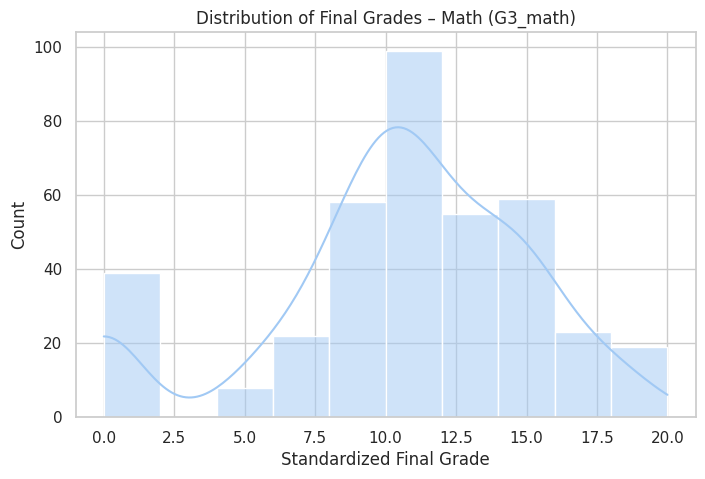

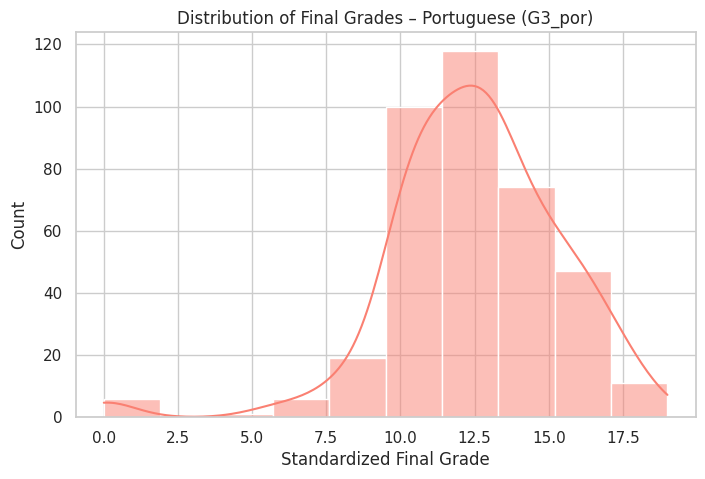

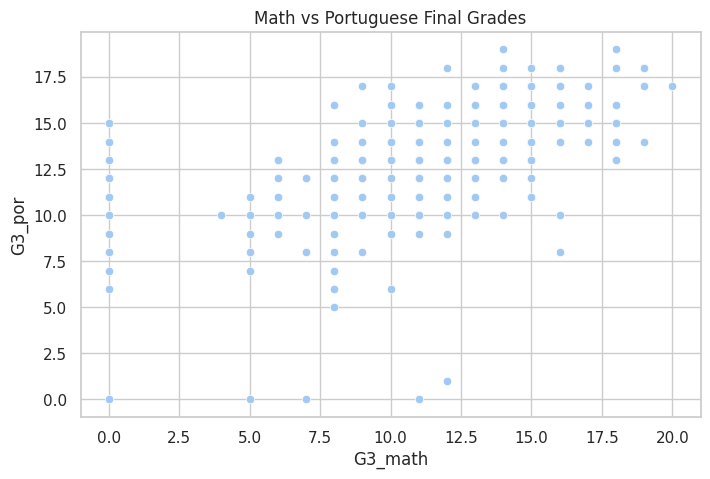

In [ ]:
# TARGET DISTRIBUTIONS

# Math final grade
sns.histplot(df["G3_math"], bins=10, kde=True)
plt.title("Distribution of Final Grades – Math (G3_math)")
plt.xlabel("Standardized Final Grade")
plt.ylabel("Count")
plt.show()

# Portuguese final grade
sns.histplot(df["G3_por"], bins=10, kde=True, color="salmon")
plt.title("Distribution of Final Grades – Portuguese (G3_por)")
plt.xlabel("Standardized Final Grade")
plt.ylabel("Count")
plt.show()

# Relationship between Math and Portuguese performance
sns.scatterplot(x="G3_math", y="G3_por", data=df)
plt.title("Math vs Portuguese Final Grades")
plt.xlabel("G3_math")
plt.ylabel("G3_por")
plt.show()

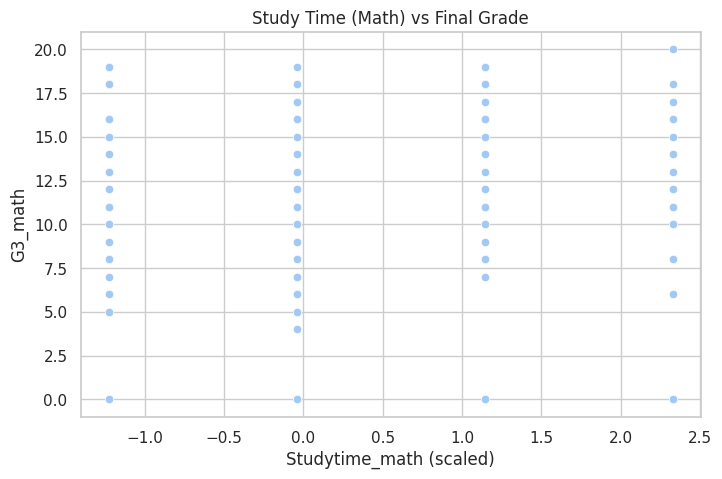

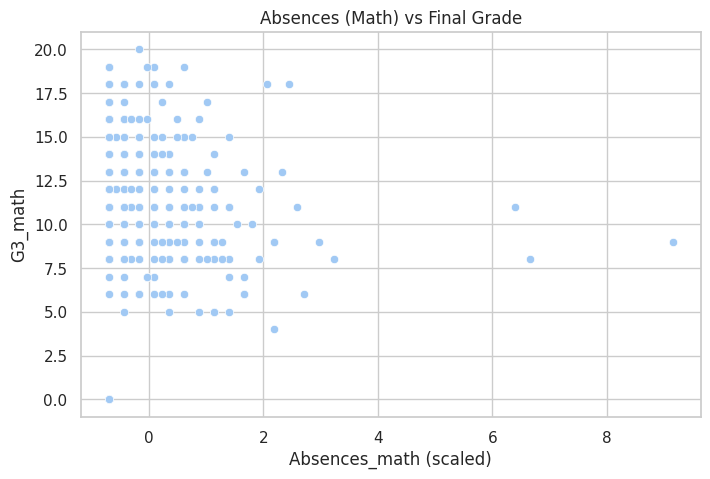

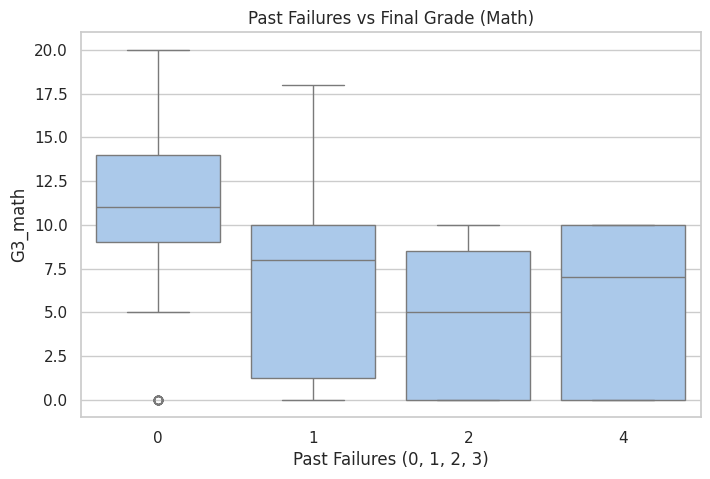

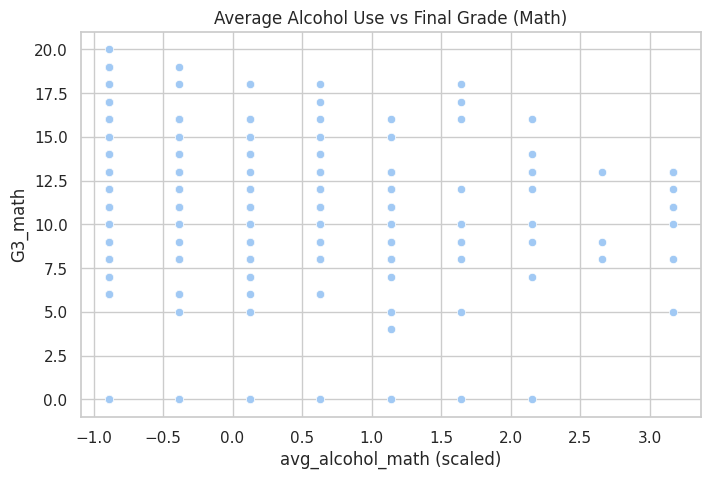

In [ ]:
# KEY RELATIONSHIPS (MATH)

# Study time vs Math grade
sns.scatterplot(x="studytime_math", y="G3_math", data=df)
plt.title("Study Time (Math) vs Final Grade")
plt.xlabel("Studytime_math (scaled)")
plt.ylabel("G3_math")
plt.show()

# Absences vs Math grade
sns.scatterplot(x="absences_math", y="G3_math", data=df)
plt.title("Absences (Math) vs Final Grade")
plt.xlabel("Absences_math (scaled)")
plt.ylabel("G3_math")
plt.show()

# FIXED: Failures vs Math grade (use categories)
df["failures_math_cat"] = df["failures_math"].round().astype(int)

sns.boxplot(x="failures_math_cat", y="G3_math", data=df)
plt.title("Past Failures vs Final Grade (Math)")
plt.xlabel("Past Failures (0, 1, 2, 3)")
plt.ylabel("G3_math")
plt.show()

# Alcohol vs Math grade
sns.scatterplot(x="avg_alcohol_math", y="G3_math", data=df)
plt.title("Average Alcohol Use vs Final Grade (Math)")
plt.xlabel("avg_alcohol_math (scaled)")
plt.ylabel("G3_math")
plt.show()


Top 10 features correlated with G3_math:


,G3_math
G3_math,1.000000
avg_grade_math,0.959719
G2_math,0.903027
G1_math,0.805129
G2_por,0.535552
avg_grade_por,0.526431
G1_por,0.495305
G3_por,0.480349
higher_math,0.232177
higher_por,0.216342



Top 10 features correlated with G3_por:


,G3_por
G3_por,1.000000
avg_grade_por,0.952412
G2_por,0.892444
G1_por,0.819048
G1_math,0.550844
avg_grade_math,0.534646
G2_math,0.507500
G3_math,0.480349
higher_por,0.311975
higher_math,0.303576


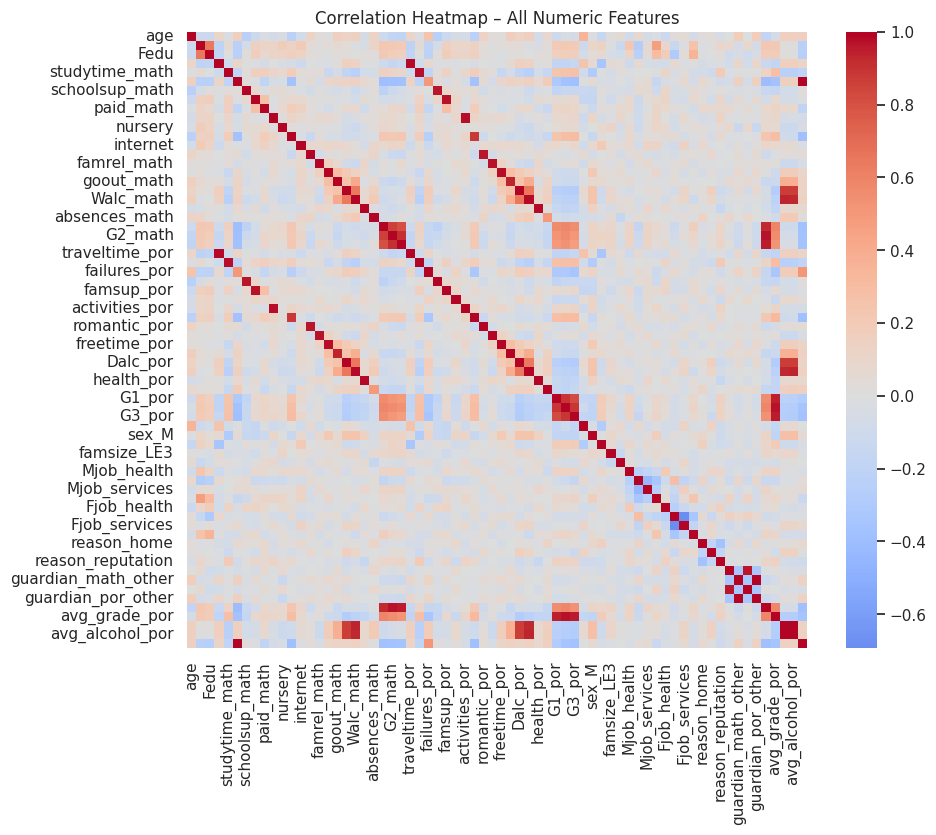

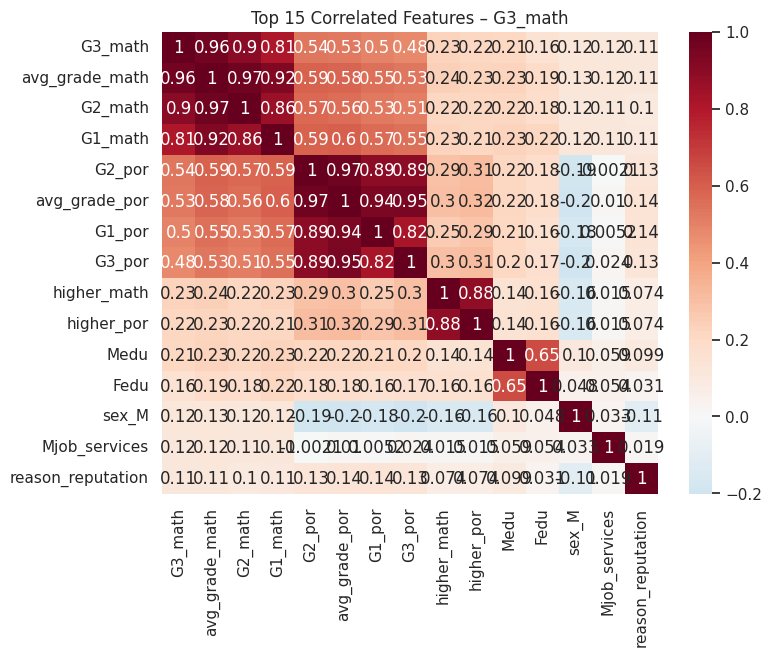

In [ ]:
# CORRELATION ANALYSIS

corr = df.corr(numeric_only=True)

# Correlation with Math and Portuguese targets
corr_math = corr["G3_math"].sort_values(ascending=False)
corr_por  = corr["G3_por"].sort_values(ascending=False)

print("\nTop 10 features correlated with G3_math:")
display(corr_math.head(10))

print("\nTop 10 features correlated with G3_por:")
display(corr_por.head(10))

# Full heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap – All Numeric Features")
plt.show()

# Focused heatmap: top 15 correlated with G3_math
top15_math = corr_math.head(15).index.tolist()
plt.figure(figsize=(8, 6))
sns.heatmap(df[top15_math].corr(), annot=True, cmap="RdBu_r", center=0)
plt.title("Top 15 Correlated Features – G3_math")
plt.show()

In [ ]:
# Remove leakage columns
leakage_cols = [
    "G1_math", "G2_math", "avg_grade_math",
    "G1_por", "G2_por", "avg_grade_por"
]

df_rfe = df.drop(columns=[c for c in leakage_cols if c in df.columns])

X_all = df_rfe.drop(columns=["G3_math", "G3_por"])
y_math = df_rfe["G3_math"]
y_por  = df_rfe["G3_por"]

linreg = LinearRegression()

# RFE for Math
rfe_math = RFE(estimator=linreg, n_features_to_select=15)
rfe_math.fit(X_all, y_math)
selected_math = X_all.columns[rfe_math.support_].tolist()

print("\nSelected features for G3_math:")
for f in selected_math: print(" -", f)

# RFE for Portuguese
rfe_por = RFE(estimator=linreg, n_features_to_select=15)
rfe_por.fit(X_all, y_por)
selected_por = X_all.columns[rfe_por.support_].tolist()

print("\nSelected features for G3_por:")
for f in selected_por: print(" -", f)



Selected features for G3_math:
 - age
 - failures_math
 - schoolsup_math
 - freetime_math
 - Dalc_math
 - Walc_math
 - absences_math
 - schoolsup_por
 - freetime_por
 - Dalc_por
 - Walc_por
 - absences_por
 - guardian_math_mother
 - guardian_por_mother
 - failures_math_cat

Selected features for G3_por:
 - failures_math
 - activities_math
 - goout_math
 - studytime_por
 - failures_por
 - schoolsup_por
 - activities_por
 - higher_por
 - goout_por
 - health_por
 - school_MS
 - sex_M
 - address_U
 - Fjob_other
 - failures_math_cat


In [ ]:
# SAVE REDUCED DATASETS

df_math_model = df[selected_math + ["G3_math"]].copy()
df_por_model  = df[selected_por + ["G3_por"]].copy()

df_math_model.to_csv("/content/student_model_input_math.csv", index=False)
df_por_model.to_csv("/content/student_model_input_por.csv", index=False)

print("\nSaved reduced datasets for modeling:")
print(" - student_model_input_math.csv → features + G3_math")
print(" - student_model_input_por.csv  → features + G3_por")

display(df_math_model.head(3))
display(df_por_model.head(3))


Saved reduced datasets for modeling:
 - student_model_input_math.csv → features + G3_math
 - student_model_input_por.csv  → features + G3_por


,age,failures_math,schoolsup_math,freetime_math,Dalc_math,Walc_math,absences_math,schoolsup_por,freetime_por,Dalc_por,Walc_por,absences_por,guardian_math_mother,guardian_por_mother,failures_math_cat,G3_math
0,1.206223,-0.398855,2.547586,-0.225458,-0.535351,-0.999156,0.089377,2.576820,-0.234159,-0.538264,-1.007557,0.066787,0.623772,0.623772,0,6
1,0.352932,-0.398855,-0.392528,-0.225458,-0.535351,-0.999156,-0.173254,-0.388075,-0.234159,-0.538264,-1.007557,-0.341415,-1.603151,-1.603151,0,6
2,-1.353650,3.719054,2.547586,-0.225458,0.594505,0.561898,0.614638,2.576820,-0.234159,0.591499,0.553850,0.474989,0.623772,0.623772,4,10


,failures_math,activities_math,goout_math,studytime_por,failures_por,schoolsup_por,activities_por,higher_por,goout_por,health_por,school_MS,sex_M,address_U,Fjob_other,failures_math_cat,G3_por
0,-0.398855,-1.053801,0.785031,-0.046499,-0.275783,2.576820,-1.048285,0.222375,0.779173,-0.410662,-0.341993,-0.963998,0.518751,-1.110819,0,11
1,-0.398855,-1.053801,-0.099576,-0.046499,-0.275783,-0.388075,-1.048285,0.222375,-0.104044,-0.410662,-0.341993,-0.963998,0.518751,0.900237,0,11
2,3.719054,-1.053801,-0.984184,-0.046499,-0.275783,2.576820,-1.048285,0.222375,-0.987260,-0.410662,-0.341993,-0.963998,0.518751,0.900237,4,12



RFE Ranking (Math) – lowest rank = most important:


,feature,rank
0,age,1
5,failures_math,1
6,schoolsup_math,1
15,freetime_math,1
24,schoolsup_por,1
20,absences_math,1
18,Walc_math,1
17,Dalc_math,1
31,freetime_por,1
36,absences_por,1


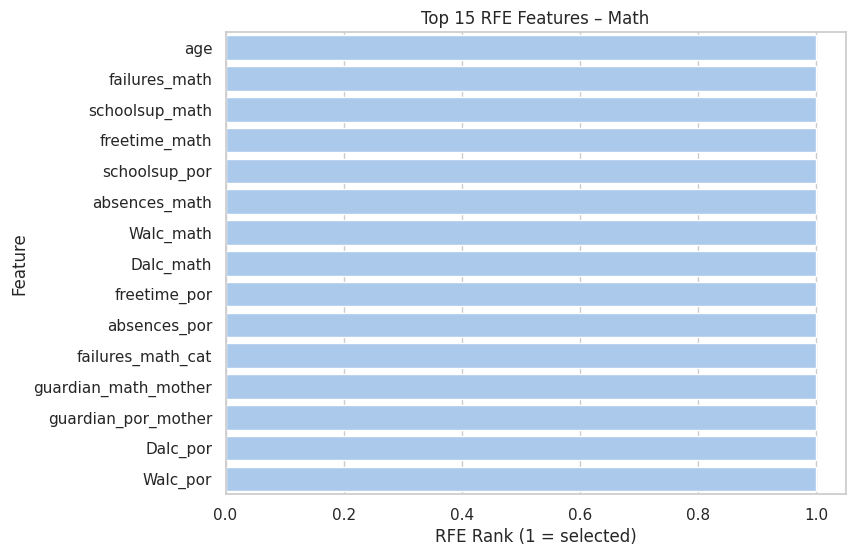

In [ ]:
# RFE FEATURE RANK VISUALIZATION

# Build ranking table for Math
ranking_math = pd.DataFrame({
    "feature": X_all.columns,
    "rank": rfe_math.ranking_
}).sort_values(by="rank")

print("\nRFE Ranking (Math) – lowest rank = most important:")
display(ranking_math.head(20))

plt.figure(figsize=(8, 6))
sns.barplot(
    x="rank",
    y="feature",
    data=ranking_math.head(15),
    orient="h"
)
plt.title("Top 15 RFE Features – Math")
plt.xlabel("RFE Rank (1 = selected)")
plt.ylabel("Feature")
plt.show()

In [ ]:
# Import required libraries for data processing, modeling, and visualization

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set plot style and figure size
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# Fix random seed for reproducibility
RANDOM_STATE = 42

# Ensure report folder exists
os.makedirs("reports/figures", exist_ok=True)


In [ ]:
# Load the pre-processed datasets created after EDA and RFE feature selection

df_math = pd.read_csv("/content/student_model_input_math.csv")
df_por  = pd.read_csv("/content/student_model_input_por.csv")

# Print dataset dimensions
print("Math dataset shape:", df_math.shape)
print("Portuguese dataset shape:", df_por.shape)

# Split into features (X) and target variable (y) for both subjects
X_math, y_math = df_math.drop("G3_math", axis=1), df_math["G3_math"]
X_por,  y_por  = df_por.drop("G3_por", axis=1),  df_por["G3_por"]

# df_math.head(3)

Math dataset shape: (382, 16)
Portuguese dataset shape: (382, 16)


In [ ]:
# Split math and Portuguese datasets into training and testing sets (80 percent train, 20 percent test)

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_math, y_math, test_size=0.2, random_state=RANDOM_STATE
)
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X_por, y_por, test_size=0.2, random_state=RANDOM_STATE
)

# Print resulting split sizes
print("Math train/test:", X_train_m.shape, X_test_m.shape)
print("Portuguese train/test:", X_train_p.shape, X_test_p.shape)


Math train/test: (305, 15) (77, 15)
Portuguese train/test: (305, 15) (77, 15)


In [ ]:
# Define three regression models to evaluate

models = {
    "Linear Regression": LinearRegression(),
    "LASSO Regression": Lasso(alpha=0.1, max_iter=10000, random_state=RANDOM_STATE),
    "Random Forest": RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE)
}

# Function to train model with scaling, run 5-fold CV, and compute evaluation metrics
def evaluate_one(X_train, y_train, X_test, y_test, est):
    """Train model in pipeline, perform 5-fold CV, and return metrics."""
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", est)
    ])

    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
 # Perform cross validation and collect metrics
    cv_res = cross_validate(
        pipe, X_train, y_train,
        scoring=("r2", "neg_mean_absolute_error", "neg_mean_squared_error"),
        cv=cv, n_jobs=-1, return_train_score=False
    )
    # Fit on training set and predict on test set
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    cv_rmse = np.sqrt(-cv_res["test_neg_mean_squared_error"])

    # Return all metrics in a dictionary
    return {
        "CV_R2": float(cv_res["test_r2"].mean()),
        "CV_MAE": float(-cv_res["test_neg_mean_absolute_error"].mean()),
        "CV_RMSE": float(cv_rmse.mean()),
        "Test_R2": float(r2_score(y_test, y_pred)),
        "Test_MAE": float(mean_absolute_error(y_test, y_pred)),
        "Test_RMSE": float(np.sqrt(mean_squared_error(y_test, y_pred))),
        "_pipe": pipe
    }


In [ ]:
# Train and evaluate all models for Math

results_math = {}
best_math = {"name": None, "score": -np.inf, "pipe": None}

for name, est in models.items():
    res = evaluate_one(X_train_m, y_train_m, X_test_m, y_test_m, est)
    results_math[name] = {k: v for k, v in res.items() if k != "_pipe"}
    if res["Test_R2"] > best_math["score"]:
        best_math.update({"name": name, "score": res["Test_R2"], "pipe": res["_pipe"]})

# Train and evaluate all models for Portuguese
results_por = {}
best_por = {"name": None, "score": -np.inf, "pipe": None}

for name, est in models.items():
    res = evaluate_one(X_train_p, y_train_p, X_test_p, y_test_p, est)
    results_por[name] = {k: v for k, v in res.items() if k != "_pipe"}
    if res["Test_R2"] > best_por["score"]:
        best_por.update({"name": name, "score": res["Test_R2"], "pipe": res["_pipe"]})

# Print best-performing model for each subject
print("Best Math model:", best_math["name"], "Test_R2 =", round(best_math["score"], 3))
print("Best Portuguese model:", best_por["name"], "Test_R2 =", round(best_por["score"], 3))

# Convert results to DataFrames for display
df_math_scores = pd.DataFrame(results_math).T
df_por_scores  = pd.DataFrame(results_por).T

display(df_math_scores)
display(df_por_scores)

# Save model comparison results
os.makedirs("reports", exist_ok=True)
df_math_scores.to_csv("reports/model_scores_math.csv", index_label="Model")
df_por_scores.to_csv("reports/model_scores_por.csv",  index_label="Model")


Best Math model: LASSO Regression Test_R2 = 0.153
Best Portuguese model: Linear Regression Test_R2 = 0.283


,CV_R2,CV_MAE,CV_RMSE,Test_R2,Test_MAE,Test_RMSE
Linear Regression,0.112911,3.358220,4.346538,0.129946,3.426889,4.406614
LASSO Regression,0.154107,3.246624,4.241291,0.152550,3.326985,4.348996
Random Forest,0.237649,3.018277,4.016339,0.056650,3.336389,4.588475


,CV_R2,CV_MAE,CV_RMSE,Test_R2,Test_MAE,Test_RMSE
Linear Regression,0.278456,1.846084,2.400846,0.283470,1.840122,2.597714
LASSO Regression,0.257891,1.878034,2.451503,0.237099,1.914240,2.680453
Random Forest,0.198436,1.938204,2.519910,0.198448,1.968951,2.747516


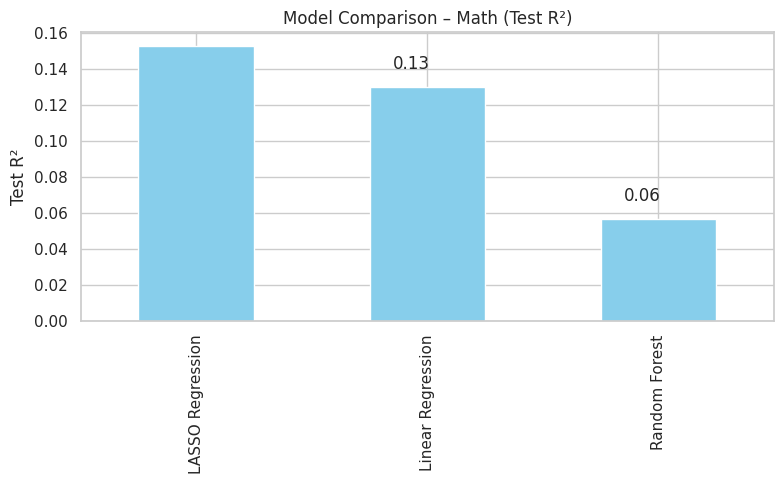

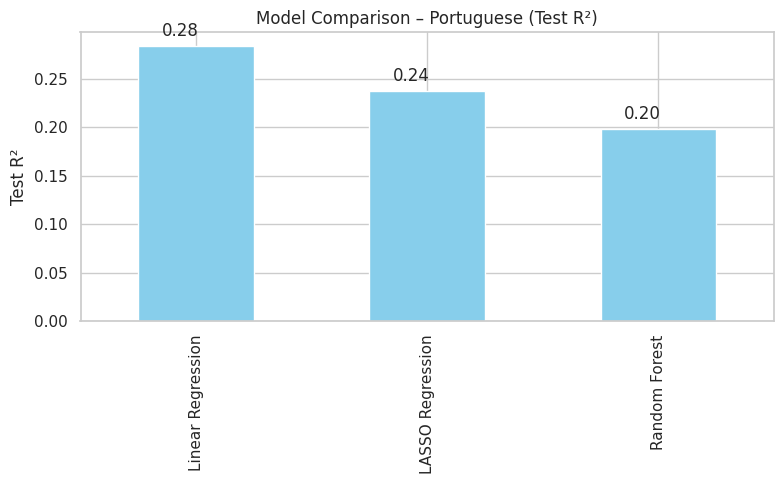

In [ ]:
# Function to plot and save bar chart of Test R² scores for all models

def plot_r2(df, title, filename):
    s = df["Test_R2"].sort_values(ascending=False)
    ax = s.plot(kind="bar", color="skyblue")
    ax.set_title(title)
    ax.set_ylabel("Test R²")
    # Annotate each bar with its R² value
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() + 0.1, p.get_height() + 0.01))
    plt.tight_layout()
    plt.savefig(f"reports/figures/{filename}", dpi=200)
    plt.show()

# Plot comparison charts for Math and Portuguese models
plot_r2(df_math_scores, "Model Comparison – Math (Test R²)", "compare_math_r2.png")
plot_r2(df_por_scores, "Model Comparison – Portuguese (Test R²)", "compare_por_r2.png")


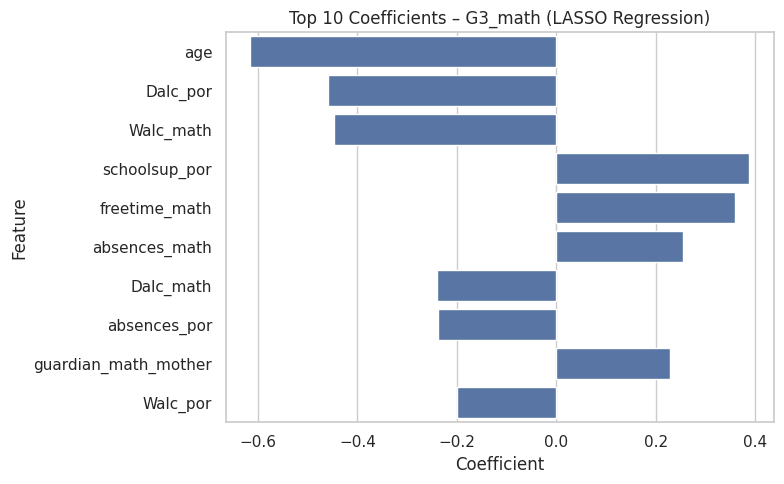

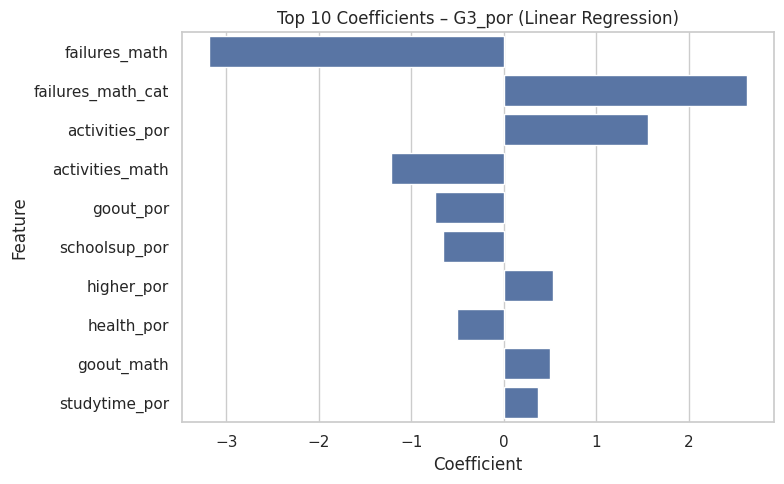

In [ ]:
# FEATURE IMPORTANCE / COEFFICIENTS

def explain_model(best_name, best_pipe, X_train, target, prefix):
    model = best_pipe.named_steps["model"]
    features = X_train.columns

    if hasattr(model, "feature_importances_"):  # For Random Forest
        imp = pd.DataFrame({"Feature": features, "Importance": model.feature_importances_})
        imp = imp.sort_values("Importance", ascending=False)
        imp.to_csv(f"reports/{prefix}_feature_importance.csv", index=False)

        sns.barplot(x="Importance", y="Feature", data=imp.head(10))
        plt.title(f"Top 10 Important Features – {target} ({best_name})")
        plt.tight_layout()
        plt.savefig(f"reports/figures/{prefix}_top10.png", dpi=200)
        plt.show()
        return imp

    elif hasattr(model, "coef_"):  # For Linear/LASSO
        coef = pd.DataFrame({
            "Feature": features,
            "Coefficient": np.ravel(model.coef_)
        }).sort_values("Coefficient", key=np.abs, ascending=False)
        coef.to_csv(f"reports/{prefix}_coefficients.csv", index=False)

        sns.barplot(x="Coefficient", y="Feature", data=coef.head(10))
        plt.title(f"Top 10 Coefficients – {target} ({best_name})")
        plt.tight_layout()
        plt.savefig(f"reports/figures/{prefix}_top10.png", dpi=200)
        plt.show()
        return coef

imp_math = explain_model(best_math["name"], best_math["pipe"], X_train_m, "G3_math", "math")
imp_por  = explain_model(best_por["name"], best_por["pipe"], X_train_p, "G3_por", "por")


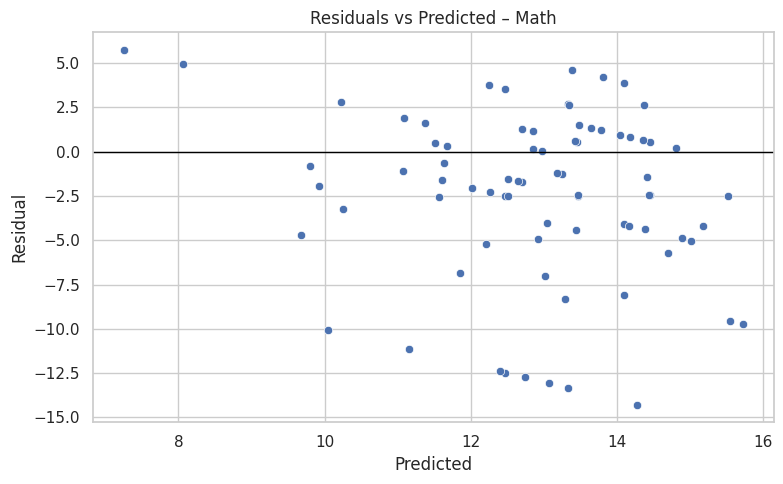

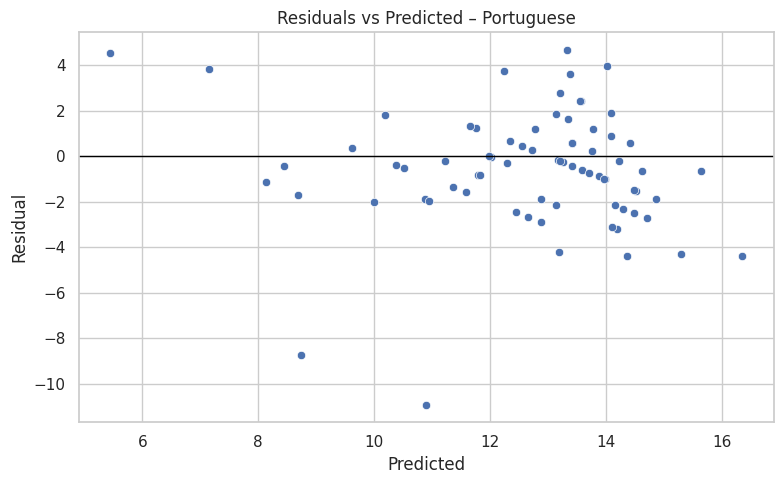

In [ ]:
# RESIDUAL ANALYSIS

def plot_residuals(pipe, X_test, y_test, title, filename):
    y_pred = pipe.predict(X_test)
    residuals = y_test - y_pred
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color="black", linewidth=1)
    plt.xlabel("Predicted")
    plt.ylabel("Residual")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"reports/figures/{filename}", dpi=200)
    plt.show()

plot_residuals(best_math["pipe"], X_test_m, y_test_m,
               "Residuals vs Predicted – Math", "residuals_math.png")

plot_residuals(best_por["pipe"], X_test_p, y_test_p,
               "Residuals vs Predicted – Portuguese", "residuals_por.png")


In [ ]:
# STEP 8 – COMBINED SUMMARY TABLE

combined = pd.concat([
    df_math_scores.assign(Target="G3_math"),
    df_por_scores.assign(Target="G3_por")
])

combined.to_csv("reports/model_comparison_summary.csv", index_label="Model")
display(combined)


,CV_R2,CV_MAE,CV_RMSE,Test_R2,Test_MAE,Test_RMSE,Target
Linear Regression,0.112911,3.358220,4.346538,0.129946,3.426889,4.406614,G3_math
LASSO Regression,0.154107,3.246624,4.241291,0.152550,3.326985,4.348996,G3_math
Random Forest,0.237649,3.018277,4.016339,0.056650,3.336389,4.588475,G3_math
Linear Regression,0.278456,1.846084,2.400846,0.283470,1.840122,2.597714,G3_por
LASSO Regression,0.257891,1.878034,2.451503,0.237099,1.914240,2.680453,G3_por
Random Forest,0.198436,1.938204,2.519910,0.198448,1.968951,2.747516,G3_por


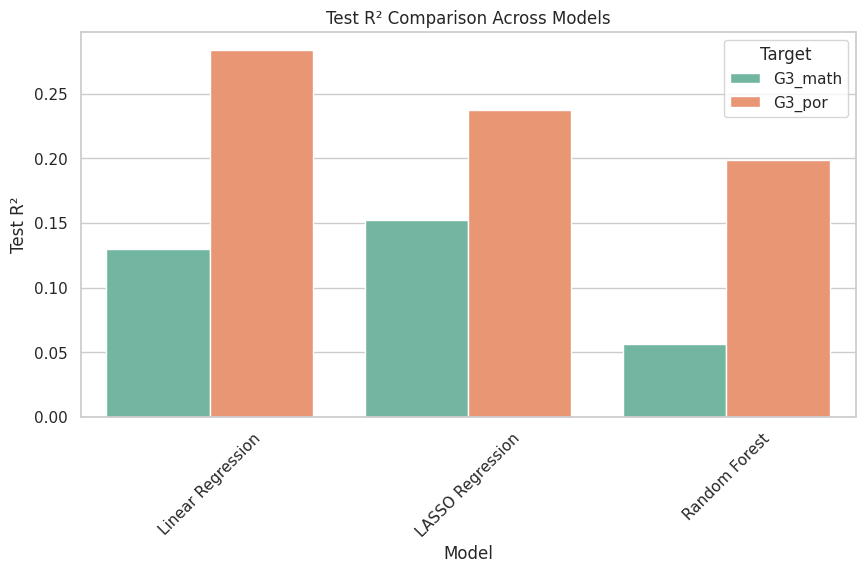

In [ ]:
# Plot a bar chart comparing Test R² values for all models across both targets
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))

sns.barplot(
    data=combined,
    x=combined.index,
    y="Test_R2",
    hue="Target",
    palette="Set2"
)

plt.title("Test R² Comparison Across Models")
plt.ylabel("Test R²")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.show()


In [ ]:
#Professor Comment
#  DATA DRIVEN THRESHOLDS FOR EVALUATION METRICS
# Here we define LOW / MEDIUM / HIGH bands for Test_R2
# based on the distribution of model performance for each Target.
# This makes thresholds depend on how the models actually perform,
# instead of using fixed arbitrary cutoffs.

# 1. Compute 33 percent and 66 percent quantiles of Test_R2 per Target
thresholds = (
    combined.groupby("Target")["Test_R2"]
    .quantile([0.33, 0.66])
    .unstack()
)

print("\nData driven Test_R2 thresholds (per target):")
print(thresholds)

# 2. Helper function to map each model to a performance band
def r2_band(row):
    q33 = thresholds.loc[row["Target"], 0.33]
    q66 = thresholds.loc[row["Target"], 0.66]
    r2  = row["Test_R2"]

    if r2 < q33:
        return "LOW"
    elif r2 < q66:
        return "MEDIUM"
    else:
        return "HIGH"

# 3. Apply the function and store band in a new column
combined["R2_band"] = combined.apply(r2_band, axis=1)

print("\nModel performance bands based on Test_R2 quantiles:")
display(combined)
combined.to_csv("reports/model_comparison_with_bands.csv", index_label="Model")



Data driven Test_R2 thresholds (per target):
             0.33      0.66
Target                     
G3_math  0.105025  0.137179
G3_por   0.223958  0.251938

Model performance bands based on Test_R2 quantiles:


,CV_R2,CV_MAE,CV_RMSE,Test_R2,Test_MAE,Test_RMSE,Target,R2_band
Linear Regression,0.112911,3.358220,4.346538,0.129946,3.426889,4.406614,G3_math,MEDIUM
LASSO Regression,0.154107,3.246624,4.241291,0.152550,3.326985,4.348996,G3_math,HIGH
Random Forest,0.237649,3.018277,4.016339,0.056650,3.336389,4.588475,G3_math,LOW
Linear Regression,0.278456,1.846084,2.400846,0.283470,1.840122,2.597714,G3_por,HIGH
LASSO Regression,0.257891,1.878034,2.451503,0.237099,1.914240,2.680453,G3_por,MEDIUM
Random Forest,0.198436,1.938204,2.519910,0.198448,1.968951,2.747516,G3_por,LOW
